# Assignment1

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import matplotlib.patches as patches
import matplotlib.cm as cm

In [2]:
from keras.optimizers import SGD
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Flatten
from keras.layers import UpSampling2D
from keras.callbacks import EarlyStopping
from keras.layers.normalization import BatchNormalization

C:\Users\Valeria\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
# On some implementations of matplotlib, you may need to change this value
IMAGE_SIZE = 72

In [4]:
def generate_a_drawing(figsize, U, V, noise=0.0):
    fig = plt.figure(figsize=(figsize,figsize))
    ax = plt.subplot(111)
    plt.axis('Off')
    ax.set_xlim(0,figsize)
    ax.set_ylim(0,figsize)
    ax.fill(U, V, "k")
    fig.canvas.draw()
    imdata = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)[::3].astype(np.float32)
    imdata = imdata + noise * np.random.random(imdata.size)
    plt.close(fig)
    return imdata

In [5]:
def generate_a_rectangle(noise=0.0, free_location=False):
    figsize = 1.0    
    U = np.zeros(4)
    V = np.zeros(4)
    if free_location:
        corners = np.random.random(4)
        top = max(corners[0], corners[1])
        bottom = min(corners[0], corners[1])
        left = min(corners[2], corners[3])
        right = max(corners[2], corners[3])
    else:
        side = (0.3 + 0.7 * np.random.random()) * figsize
        top = figsize/2 + side/2
        bottom = figsize/2 - side/2
        left = bottom
        right = top
    U[0] = U[1] = top
    U[2] = U[3] = bottom
    V[0] = V[3] = left
    V[1] = V[2] = right
    return generate_a_drawing(figsize, U, V, noise)

In [6]:
def generate_a_disk(noise=0.0, free_location=False):
    figsize = 1.0
    if free_location:
        center = np.random.random(2)
    else:
        center = (figsize/2, figsize/2)
    radius = (0.3 + 0.7 * np.random.random()) * figsize/2
    N = 50
    U = np.zeros(N)
    V = np.zeros(N)
    i = 0
    for t in np.linspace(0, 2*np.pi, N):
        U[i] = center[0] + np.cos(t) * radius
        V[i] = center[1] + np.sin(t) * radius
        i = i + 1
    return generate_a_drawing(figsize, U, V, noise)

In [7]:
def generate_a_triangle(noise=0.0, free_location=False):
    figsize = 1.0
    if free_location:
        U = np.random.random(3)
        V = np.random.random(3)
    else:
        size = (0.3 + 0.7 * np.random.random())*figsize/2
        middle = figsize/2
        U = (middle, middle+size, middle-size)
        V = (middle+size, middle-size, middle-size)
    imdata = generate_a_drawing(figsize, U, V, noise)
    return [imdata, [U[0], V[0], U[1], V[1], U[2], V[2]]]

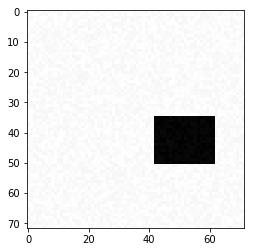

In [8]:
im = generate_a_rectangle(10, True)
plt.imshow(im.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')

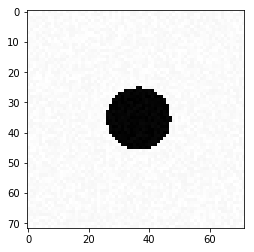

In [9]:
im = generate_a_disk(10)
plt.imshow(im.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')

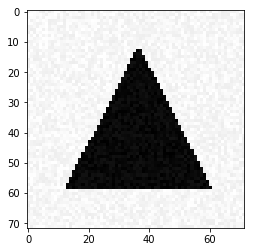

In [10]:
[im, v] = generate_a_triangle(20, False)
plt.imshow(im.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')

In [11]:
def generate_dataset_classification(nb_samples, noise=0.0, free_location=False):
    # Getting im_size:
    im_size = generate_a_rectangle().shape[0]
    X = np.zeros([nb_samples,im_size])
    Y = np.zeros(nb_samples)
    print('Creating data:')
    for i in range(nb_samples):
        if i % 10 == 0:
            print(i)
        category = np.random.randint(3)
        if category == 0:
            X[i] = generate_a_rectangle(noise, free_location)
        elif category == 1: 
            X[i] = generate_a_disk(noise, free_location)
        else:
            [X[i], V] = generate_a_triangle(noise, free_location)
        Y[i] = category
    X = (X + noise) / (255 + 2 * noise)
    return [X, Y]

In [12]:
def generate_test_set_classification():
    np.random.seed(42)
    [X_test, Y_test] = generate_dataset_classification(300, 20, True)
    Y_test = np_utils.to_categorical(Y_test, 3) 
    return [X_test, Y_test]

In [13]:
def generate_dataset_regression(nb_samples, noise=0.0):
    # Getting im_size:
    im_size = generate_a_triangle()[0].shape[0]
    X = np.zeros([nb_samples,im_size])
    Y = np.zeros([nb_samples, 6])
    print('Creating data:')
    for i in range(nb_samples):
        if i % 10 == 0:
            print(i)
        [X[i], Y[i]] = generate_a_triangle(noise, True)
    X = (X + noise) / (255 + 2 * noise)
    return [X, Y]

In [14]:
def visualize_prediction(x, y):
    fig, ax = plt.subplots(figsize=(5, 5))
    I = x.reshape((IMAGE_SIZE,IMAGE_SIZE))
    ax.imshow(I, extent=[-0.15,1.15,-0.15,1.15],cmap='gray')
    ax.set_xlim([0,1])
    ax.set_ylim([0,1])

    xy = y.reshape(3,2)
    tri = patches.Polygon(xy, closed=True, fill = False, edgecolor = 'r', linewidth = 5, alpha = 0.5)
    ax.add_patch(tri)

    plt.show()

In [15]:
def generate_test_set_regression():
    np.random.seed(42)
    [X_test, Y_test] = generate_dataset_regression(300, 20)
    return [X_test, Y_test]

## 3 Simple Classifcation

For linear classifier NN with fully connected layers was used. Output was transformed into 3 categories as the types of figures.
With both optimizers (SGD and adam) the model is able to predict the shape. Even though adam optimizer is supposed to perform 
faster and better, SGD also shows very low loss, meaning that they both reached the same minimum.

In [16]:
# generate dataset
[X_train_1, Y_train_1] = generate_dataset_classification(300, 20)

Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290


In [17]:
X_train_1[0].shape

(5184,)

In [18]:
# transform output to categorical
print(Y_train_1.shape)
print(Y_train_1[0:6])

Y_train_1 = np_utils.to_categorical(Y_train_1, 3)
print(Y_train_1[0])
print(Y_train_1[1])

(300,)
[2. 2. 2. 1. 2. 1.]
[0. 0. 1.]
[0. 0. 1.]


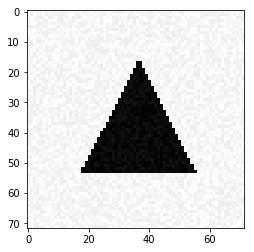

In [19]:
plt.imshow(X_train_1[0].reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')

In [20]:
# create a model

model_1 = Sequential()

model_1.add(Dense(20, activation='relu', input_shape=(5184,)))
model_1.add(Dense(10, activation='relu'))
model_1.add(Dense(10, activation='relu'))
model_1.add(Dense(3, activation='softmax'))

In [21]:
print(model_1.output_shape)

(None, 3)


Optimize with stochastic gradient

In [22]:
sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model_1.compile(loss='mean_squared_error', optimizer=sgd)

In [23]:
callback = EarlyStopping(monitor='val_loss', patience=2)

In [24]:
# train the model
model_1.fit(X_train_1, Y_train_1, epochs=10, batch_size=32, validation_split=0.2, callbacks=[callback])

Train on 240 samples, validate on 60 samples
Epoch 1/10
240/240 [==============================] - 0s 732us/step - loss: 0.2261 - val_loss: 0.2123
Epoch 2/10
240/240 [==============================] - 0s 111us/step - loss: 0.2039 - val_loss: 0.1908
Epoch 3/10
240/240 [==============================] - 0s 121us/step - loss: 0.1803 - val_loss: 0.1850
Epoch 4/10
240/240 [==============================] - 0s 133us/step - loss: 0.1624 - val_loss: 0.1306
Epoch 5/10
240/240 [==============================] - 0s 121us/step - loss: 0.1241 - val_loss: 0.1338
Epoch 6/10
240/240 [==============================] - 0s 145us/step - loss: 0.1128 - val_loss: 0.1023
Epoch 7/10
240/240 [==============================] - 0s 129us/step - loss: 0.1067 - val_loss: 0.0889
Epoch 8/10
240/240 [==============================] - 0s 125us/step - loss: 0.0815 - val_loss: 0.0803
Epoch 9/10
240/240 [==============================] - 0s 121us/step - loss: 0.0759 - val_loss: 0.0665
Epoch 10/10
240/240 [================

In [25]:
X_test_1 = generate_a_disk()
X_test_1 = X_test_1.reshape(1, X_test_1.shape[0])

In [26]:
# make predictions
Y_pred_1 = model_1.predict(X_test_1)
Y_pred_1

array([[0., 1., 0.]], dtype=float32)

The model predicted disc succesfully 

Optimize with adam optimizer

In [27]:
model_1.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [28]:
model_1.fit(X_train_1, Y_train_1, epochs=10, batch_size=32, validation_split=0.2, callbacks=[callback])

Train on 240 samples, validate on 60 samples
Epoch 1/10
240/240 [==============================] - 0s 1ms/step - loss: 1.2434 - acc: 0.4792 - val_loss: 0.7452 - val_acc: 0.7167
Epoch 2/10
240/240 [==============================] - 0s 162us/step - loss: 0.7079 - acc: 0.6708 - val_loss: 0.7176 - val_acc: 0.5833
Epoch 3/10
240/240 [==============================] - 0s 170us/step - loss: 0.4543 - acc: 0.7667 - val_loss: 0.3469 - val_acc: 0.8167
Epoch 4/10
240/240 [==============================] - 0s 150us/step - loss: 0.3587 - acc: 0.8292 - val_loss: 0.3437 - val_acc: 0.8500
Epoch 5/10
240/240 [==============================] - 0s 141us/step - loss: 0.3547 - acc: 0.8208 - val_loss: 0.3985 - val_acc: 0.7167
Epoch 6/10
240/240 [==============================] - 0s 121us/step - loss: 0.3010 - acc: 0.8875 - val_loss: 0.2902 - val_acc: 0.9500
Epoch 7/10
240/240 [==============================] - 0s 133us/step - loss: 0.2802 - acc: 0.9333 - val_loss: 0.2723 - val_acc: 0.9500
Epoch 8/10
240/240 

In [29]:
# make predictions
Y_pred_2 = model_1.predict(X_test_1)
Y_pred_2

array([[0., 1., 0.]], dtype=float32)

The model predicted disc succesfully 

## 4 Visualization of the Solution

Weights are the coefficient of the model on each layer. Since suggested model has 2 hidden layers the coefficients of 
the input layer nuerons (plotted below) cannot capture the shape yet. 

In [30]:
weights = model_1.get_weights()
weights[0].shape

(5184, 20)

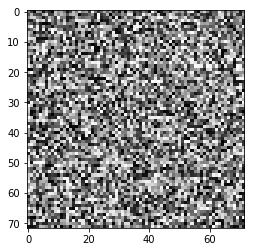

In [31]:
%matplotlib inline
plt.imshow(weights[0][:,0].reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')

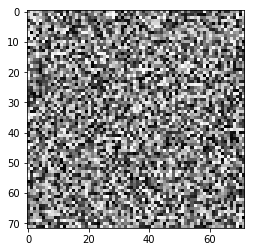

In [32]:
plt.imshow(weights[0][:,1].reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')

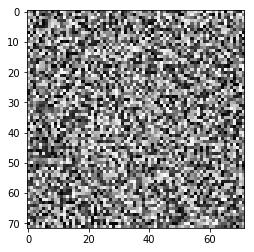

In [33]:
plt.imshow(weights[0][:,2].reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')

## 5 A More Difficult Classification Problem

To deal with more complex problem NN with convolutional layers was used. Convolutional layers are supposed to work much better with images, which can improve the model (in comparison to model in problem 3). Gained accuracy was aroung 65%

In [34]:
# generate dataset
[X_train_2, Y_train_2] = generate_dataset_classification(300, 20, True)

Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290


In [35]:
# reshape input as image
X_train_2 = X_train_2.reshape(X_train_2.shape[0], 72, 72, 1)
X_train_2 = X_train_2.astype('float32')
X_train_2 /= 255
print(X_train_2.shape)

(300, 72, 72, 1)


In [36]:
# transform output to categorical
print(Y_train_2.shape)
print(Y_train_2[0:6])
Y_train_2 = np_utils.to_categorical(Y_train_2, 3)
print(Y_train_2[0])
print(Y_train_2[1])

(300,)
[1. 2. 1. 1. 1. 0.]
[0. 1. 0.]
[0. 0. 1.]


In [37]:
# create a model

model_2 = Sequential()

model_2.add(Conv2D(16, (5, 5), activation='relu', input_shape=(72, 72, 1)))
print(model_2.output_shape)

model_2.add(MaxPooling2D(pool_size=(2, 2)))
print(model_2.output_shape)

model_2.add(Flatten())
print(model_2.output_shape)

model_2.add(Dense(128, activation='relu'))
print(model_2.output_shape)

model_2.add(Dense(3, activation='sigmoid'))
print(model_2.output_shape)

(None, 68, 68, 16)
(None, 34, 34, 16)
(None, 18496)
(None, 128)
(None, 3)


In [38]:
model_2.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

In [39]:
# train the model
model_2.fit(X_train_2, Y_train_2, batch_size=16, epochs=10, verbose=1, validation_split=0.2, callbacks=[callback])

Train on 240 samples, validate on 60 samples
Epoch 1/10
240/240 [==============================] - 1s 6ms/step - loss: 0.6509 - acc: 0.6444 - val_loss: 0.6412 - val_acc: 0.6667
Epoch 2/10
240/240 [==============================] - 1s 4ms/step - loss: 0.6373 - acc: 0.6667 - val_loss: 0.6428 - val_acc: 0.6667
Epoch 3/10
240/240 [==============================] - 1s 5ms/step - loss: 0.6389 - acc: 0.6667 - val_loss: 0.6422 - val_acc: 0.6667


In [40]:
# generate test set
[X_test_2, Y_test_2] = generate_test_set_classification()

Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290


In [41]:
# reshape input as image
X_test_2 = X_test_2.reshape(X_test_2.shape[0], 72, 72, 1)
X_test_2 = X_test_2.astype('float32')
X_test_2 /= 255
print(X_test_2.shape)

(300, 72, 72, 1)


In [42]:
Y_test_2.shape
Y_test_2[0]

array([0., 1., 0.], dtype=float32)

In [43]:
# evaluate the model
model_2.evaluate(X_test_2, Y_test_2)

300/300 [==============================] - 0s 1ms/step


[0.6388259824117025, 0.6666666865348816]

In [44]:
model_2.metrics_names

['loss', 'acc']

In [45]:
print(model_2.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 68, 68, 16)        416       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 34, 34, 16)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 18496)             0         
_________________________________________________________________
dense_5 (Dense)              (None, 128)               2367616   
_________________________________________________________________
dense_6 (Dense)              (None, 3)                 387       
Total params: 2,368,419
Trainable params: 2,368,419
Non-trainable params: 0
_________________________________________________________________
None


## 6 A Regression Problem

For the regression problem NN with fully connected layers was used. Prior to train and test output Y was normalized with respect to distance fron origin. The resulted accuracy of the model (for train, validation and test) is around 50 - 60%

In [46]:
# generate dataset
[X_train_3, Y_train_3] = generate_dataset_regression(1000, 20)

Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780
790
800
810
820
830
840
850
860
870
880
890
900
910
920
930
940
950
960
970
980
990


In [47]:
X_train_3.shape

(1000, 5184)

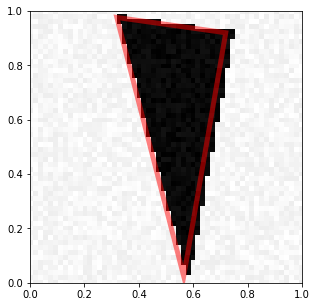

In [48]:
visualize_prediction(X_train_3[0], Y_train_3[0])

In [49]:
# Normalize output: sort according to euclidian distance from the origin

Y_train_3_norm = []
for i in range(Y_train_3.shape[0]):
    Y_train_3_1 = Y_train_3[i].reshape(3,2)
    V = []
    for j in range(3):
        v = np.power((Y_train_3_1[j][0]*Y_train_3_1[j][0] + Y_train_3_1[j][1]*Y_train_3_1[j][1]),0.5)
        V.append(v)
    s = np.argsort(V)
    Y_train_3_2 = Y_train_3_1[s]
    Y_train_3_2 = Y_train_3_2.reshape(1,6)
    Y_train_3_norm.append(Y_train_3_2[0])
Y_train_3_norm = np.asarray(Y_train_3_norm)

In [50]:
print(Y_train_3[1])
print(Y_train_3_norm[1])
print(Y_train_3.shape)
print(Y_train_3_norm.shape)

[0.45803212 0.09377698 0.5897701  0.4675181  0.05955469 0.72586894]
[0.45803212 0.09377698 0.05955469 0.72586894 0.5897701  0.4675181 ]
(1000, 6)
(1000, 6)


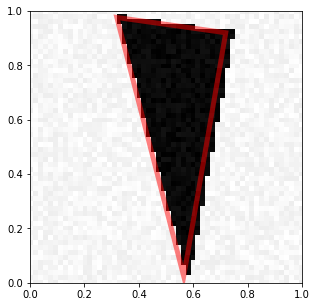

In [51]:
visualize_prediction(X_train_3[0], Y_train_3_norm[0])

In [52]:
# create a model

model_3 = Sequential()

model_3.add(Dense(200, activation ='relu', kernel_initializer='normal', input_shape = (5184,)))
model_3.add(Dense(160, activation ='relu', kernel_initializer='normal'))
model_3.add(Dense(80, activation ='relu', kernel_initializer='normal'))
model_3.add(Dense(20, activation ='relu', kernel_initializer='normal'))
model_3.add(Dense(6, activation ='sigmoid', kernel_initializer='normal'))

In [53]:
model_3.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])

In [54]:
callback = EarlyStopping(monitor='val_loss', patience=2)

In [55]:
# train the model
model_3.fit(X_train_3, Y_train_3_norm, batch_size=32, epochs=10, verbose=1, validation_split=0.2, callbacks=[callback])

Train on 800 samples, validate on 200 samples
Epoch 1/10
800/800 [==============================] - 1s 1ms/step - loss: 0.0664 - acc: 0.4062 - val_loss: 0.0640 - val_acc: 0.4250
Epoch 2/10
800/800 [==============================] - 1s 813us/step - loss: 0.0633 - acc: 0.4238 - val_loss: 0.0614 - val_acc: 0.4450
Epoch 3/10
800/800 [==============================] - 1s 851us/step - loss: 0.0603 - acc: 0.4413 - val_loss: 0.0574 - val_acc: 0.4300
Epoch 4/10
800/800 [==============================] - 1s 830us/step - loss: 0.0568 - acc: 0.4950 - val_loss: 0.0532 - val_acc: 0.6000
Epoch 5/10
800/800 [==============================] - 1s 837us/step - loss: 0.0534 - acc: 0.5087 - val_loss: 0.0493 - val_acc: 0.5050
Epoch 6/10
800/800 [==============================] - 1s 800us/step - loss: 0.0515 - acc: 0.5225 - val_loss: 0.0483 - val_acc: 0.5150
Epoch 7/10
800/800 [==============================] - 1s 778us/step - loss: 0.0457 - acc: 0.5775 - val_loss: 0.0410 - val_acc: 0.6250
Epoch 8/10
800/800

In [56]:
# generate test set
[X_test_3, Y_test_3] = generate_test_set_regression()

Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290


In [57]:
# Normalize output: sort according to euclidian distance from the origin
Y_test_3_norm = []
for i in range(Y_test_3.shape[0]):
    Y_test_3_1 = Y_test_3[i].reshape(3,2)
    V = []
    for j in range(3):
        v = np.power((Y_test_3_1[j][0]*Y_test_3_1[j][0] + Y_test_3_1[j][1]*Y_test_3_1[j][1]),0.5)
        V.append(v)
    s = np.argsort(V)
    Y_test_3_2 = Y_test_3_1[s]
    Y_test_3_2 = Y_test_3_2.reshape(1,6)
    Y_test_3_norm.append(Y_test_3_2[0])
Y_test_3_norm = np.asarray(Y_test_3_norm)

In [58]:
# evaluate the model
model_3.evaluate(X_test_3, Y_test_3_norm)

300/300 [==============================] - 0s 103us/step


[0.042264249523480735, 0.6099999992052714]

In [59]:
Y_pred_3 = model_3.predict(X_test_3)

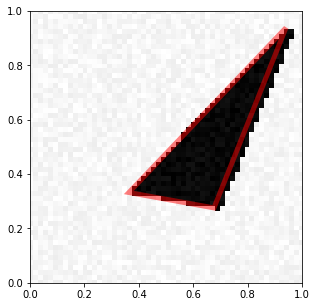

In [60]:
visualize_prediction(X_test_3[0], Y_test_3[0])

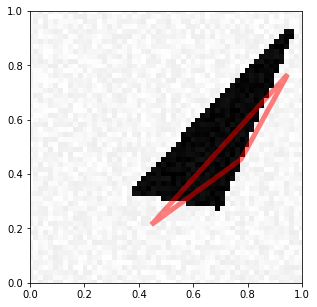

In [61]:
visualize_prediction(X_test_3[0], Y_pred_3[0])

## 7 Image Denoising

For image denoising CNN was used with hourglass architecture, which is widely used for problems with images. In additional to convolutional and pooling also upsampling layer was used in order to come back to initial dimantion of the image. The model performed well on training and validation. However, the test accuracy is around 25% even though model was checked for overfitting.

In [62]:
# Modify functions to create peirs of images (with and without noise)
def generate_a_rectangle_pairs(noise = 0.0, free_location=False):
    figsize = 1.0    
    U = np.zeros(4)
    V = np.zeros(4)
    noise_r = 200*np.random.random()
    if free_location:
        corners = np.random.random(4)
        top = max(corners[0], corners[1])
        bottom = min(corners[0], corners[1])
        left = min(corners[2], corners[3])
        right = max(corners[2], corners[3])
    else:
        side = (0.3 + 0.7 * np.random.random()) * figsize
        top = figsize/2 + side/2
        bottom = figsize/2 - side/2
        left = bottom
        right = top
    U[0] = U[1] = top
    U[2] = U[3] = bottom
    V[0] = V[3] = left
    V[1] = V[2] = right
    Y = generate_a_drawing(figsize, U, V, noise = 0.0)
    X = generate_a_drawing(figsize, U, V, noise_r)
    return [X,Y]

In [63]:
RX_4, RY_4 = generate_a_rectangle_pairs()
RX_4 = RX_4.reshape(1, RX_4.shape[0])
RY_4 = RY_4.reshape(1, RY_4.shape[0])

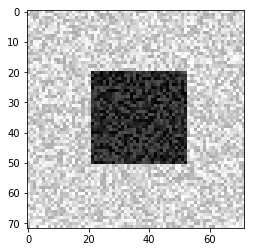

In [64]:
plt.imshow(RX_4.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')

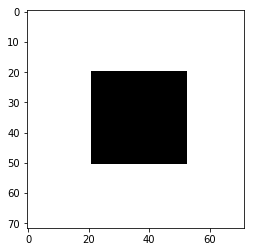

In [65]:
plt.imshow(RY_4.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')

In [66]:
def generate_a_disk_pairs(noise=0.0, free_location=False):
    figsize = 1.0
    noise_r = 200*np.random.random()
    if free_location:
        center = np.random.random(2)
    else:
        center = (figsize/2, figsize/2)
    radius = (0.3 + 0.7 * np.random.random()) * figsize/2
    N = 50
    U = np.zeros(N)
    V = np.zeros(N)
    i = 0
    for t in np.linspace(0, 2*np.pi, N):
        U[i] = center[0] + np.cos(t) * radius
        V[i] = center[1] + np.sin(t) * radius
        i = i + 1
    Y = generate_a_drawing(figsize, U, V, noise)
    X = generate_a_drawing(figsize, U, V, noise_r)
    return [X,Y]

In [67]:
DX_4, DY_4 = generate_a_disk_pairs()
DX_4 = DX_4.reshape(1, DX_4.shape[0])
DY_4 = DY_4.reshape(1, DY_4.shape[0])

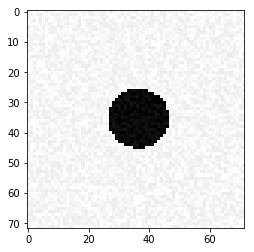

In [68]:
plt.imshow(DX_4.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')

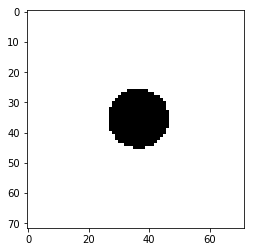

In [69]:
plt.imshow(DY_4.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')

In [70]:
def generate_a_triangle_pairs(noise=0.0, free_location=False):
    figsize = 1.0
    noise_r = 200*np.random.random()
    if free_location:
        U = np.random.random(3)
        V = np.random.random(3)
    else:
        size = (0.3 + 0.7 * np.random.random())*figsize/2
        middle = figsize/2
        U = (middle, middle+size, middle-size)
        V = (middle+size, middle-size, middle-size)
    Y = generate_a_drawing(figsize, U, V, noise)
    X = generate_a_drawing(figsize, U, V, noise_r)
    return [X,Y]

In [71]:
TX_4, TY_4 = generate_a_triangle_pairs()
TX_4 = TX_4.reshape(1, TX_4.shape[0])
TY_4 = TY_4.reshape(1, TY_4.shape[0])

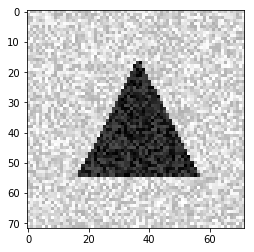

In [72]:
plt.imshow(TX_4.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')

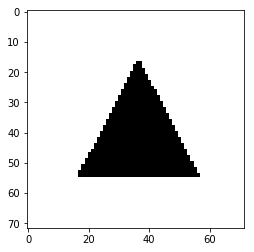

In [73]:
plt.imshow(TY_4.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')

In [74]:
def generate_dataset_pairs(nb_samples, noise=0.0, free_location=False):
    # Getting im_size:
    #im_size = generate_a_rectangle_pairs().shape[0]
    X = np.zeros([nb_samples,5184])
    Y = np.zeros([nb_samples,5184])
    print('Creating data:')
    for i in range(nb_samples):
        if i % 10 == 0:
            print(i)
        category = np.random.randint(3)
        if category == 0:
            X[i], Y[i] = generate_a_rectangle_pairs(noise = 0.0, free_location=False)
        elif category == 1: 
            X[i], Y[i] = generate_a_disk_pairs(noise = 0.0, free_location=False)
        else:
            X[i], Y[i] = generate_a_triangle_pairs(noise = 0.0, free_location=False)
    return [X, Y]

In [75]:
# generate dataset
X_train_4, Y_train_4 = generate_dataset_pairs(300)

Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290


In [76]:
Y_train_4.shape

(300, 5184)

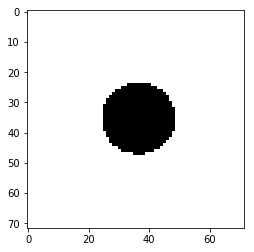

In [77]:
plt.imshow(Y_train_4[0].reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')

In [78]:
# reshape input as image

X_train_4 = X_train_4.reshape(X_train_4.shape[0], 72, 72, 1)
X_train_4 = X_train_4.astype('float32')
X_train_4 /= 255
print(X_train_4.shape)

(300, 72, 72, 1)


In [79]:
# reshape output as image

Y_train_4 = Y_train_4.reshape(Y_train_4.shape[0], 72, 72, 1)
Y_train_4 = Y_train_4.astype('float32')
Y_train_4 /= 255
print(Y_train_4.shape)

(300, 72, 72, 1)


In [80]:
# create a model

model_4 = Sequential()

model_4.add(Conv2D(16, (3,3), activation='relu', input_shape=(72,72,1), padding='same'))
model_4.add(MaxPooling2D((2), padding = 'same'))
print(model_4.output_shape)

model_4.add(Conv2D(32, kernel_size = 3, activation='relu', padding='same'))
model_4.add(MaxPooling2D((2), padding = 'same'))
print(model_4.output_shape)

model_4.add(Conv2D(64, kernel_size = 3, activation='relu', padding='same'))
model_4.add(MaxPooling2D((2), padding = 'same'))
print(model_4.output_shape)

model_4.add(UpSampling2D(size = (2,2)))

model_4.add(Conv2D(32, kernel_size = 3, activation='relu', padding='same'))
print(model_4.output_shape)

model_4.add(UpSampling2D(size = (2,2)))
model_4.add(Conv2D(16, kernel_size = 3, activation='relu', padding='same'))
print(model_4.output_shape)

model_4.add(UpSampling2D(size = (2,2)))
model_4.add(Conv2D(1, kernel_size = 3, activation='sigmoid', padding='same'))
print(model_4.output_shape)

(None, 36, 36, 16)
(None, 18, 18, 32)
(None, 9, 9, 64)
(None, 18, 18, 32)
(None, 36, 36, 16)
(None, 72, 72, 1)


In [81]:
model_4.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])

In [82]:
callback = EarlyStopping(monitor='val_loss', patience=2)

In [83]:
# train the model

model_4.fit(X_train_4, Y_train_4, batch_size=32, epochs=10, verbose=1, validation_split=0.4, callbacks=[callback])

Train on 180 samples, validate on 120 samples
Epoch 1/10
180/180 [==============================] - 3s 16ms/step - loss: 0.2280 - acc: 0.6662 - val_loss: 0.1675 - val_acc: 0.7927
Epoch 2/10
180/180 [==============================] - 2s 14ms/step - loss: 0.1529 - acc: 0.7996 - val_loss: 0.1596 - val_acc: 0.7928
Epoch 3/10
180/180 [==============================] - 3s 15ms/step - loss: 0.1397 - acc: 0.7996 - val_loss: 0.1324 - val_acc: 0.7931
Epoch 4/10
180/180 [==============================] - 3s 16ms/step - loss: 0.1148 - acc: 0.8012 - val_loss: 0.0932 - val_acc: 0.8267
Epoch 5/10
180/180 [==============================] - 3s 16ms/step - loss: 0.0775 - acc: 0.9009 - val_loss: 0.0517 - val_acc: 0.9656
Epoch 6/10
180/180 [==============================] - 3s 16ms/step - loss: 0.0370 - acc: 0.9764 - val_loss: 0.0175 - val_acc: 0.9847
Epoch 7/10
180/180 [==============================] - 3s 16ms/step - loss: 0.0141 - acc: 0.9836 - val_loss: 0.0193 - val_acc: 0.9733
Epoch 8/10
180/180 [===

In [84]:
# generate test set
X_test_4, Y_test_4 = generate_dataset_pairs(10)

Creating data:
0


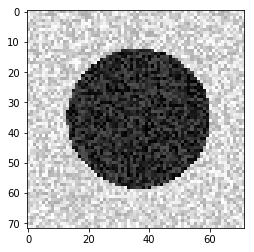

In [85]:
plt.imshow(X_test_4[0].reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')

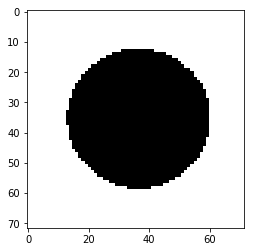

In [86]:
plt.imshow(Y_test_4[0].reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')

In [87]:
# make predictions
Y_pred_4 = model_4.predict(X_test_4.reshape(X_test_4.shape[0], 72, 72, 1))
Y_pred_4.shape

(10, 72, 72, 1)

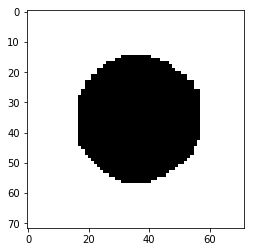

In [88]:
plt.imshow(Y_pred_4[0].reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')

In [89]:
# evaluate the model
model_4.evaluate(X_test_4.reshape(X_test_4.shape[0], 72, 72, 1), Y_test_4.reshape(Y_test_4.shape[0], 72, 72, 1))

10/10 [==============================] - 0s 4ms/step


[53134.8515625, 0.13670910894870758]

Train on 180 samples, validate on 120 samples
Epoch 1/10
180/180 [==============================] - 3s 16ms/step - loss: 0.0101 - acc: 0.9863 - val_loss: 0.0090 - val_acc: 0.9881
Epoch 2/10
180/180 [==============================] - 3s 16ms/step - loss: 0.0088 - acc: 0.9882 - val_loss: 0.0087 - val_acc: 0.9888
Epoch 3/10
180/180 [==============================] - 3s 15ms/step - loss: 0.0080 - acc: 0.9893 - val_loss: 0.0085 - val_acc: 0.9890
Epoch 4/10
180/180 [==============================] - 3s 15ms/step - loss: 0.0077 - acc: 0.9898 - val_loss: 0.0081 - val_acc: 0.9895
Epoch 5/10
180/180 [==============================] - 3s 15ms/step - loss: 0.0075 - acc: 0.9902 - val_loss: 0.0080 - val_acc: 0.9896
Epoch 6/10
180/180 [==============================] - 3s 15ms/step - loss: 0.0074 - acc: 0.9903 - val_loss: 0.0078 - val_acc: 0.9900
Epoch 7/10
180/180 [==============================] - 3s 16ms/step - loss: 0.0071 - acc: 0.9908 - val_loss: 0.0076 - val_acc: 0.9901
Epoch 8/10
180/180 [===

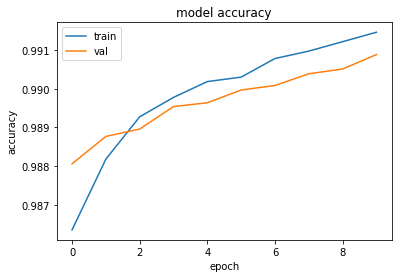

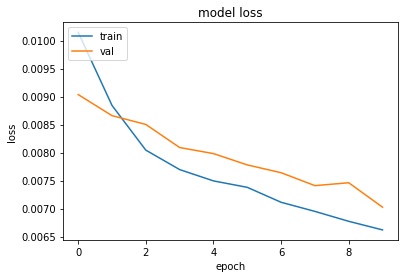

In [90]:
# Check overfitting
history = model_4.fit(X_train_4, Y_train_4, batch_size=32, epochs=10, verbose=1, validation_split=0.4, callbacks=[callback])

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()